In [1]:
import os
from utils.configuration import *
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

In [2]:
experiment_name = "dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes"      ## <--- set experiment name
LOG_DIR="/home/bule/TramDag/dev_experiment_logs"  ## <--- set log directory
EXPERIMENT_DIR = os.path.join(LOG_DIR, experiment_name)
CONF_DICT_PATH = os.path.join(EXPERIMENT_DIR, f"configuration.json")

In [3]:
setup_configuration(experiment_name,EXPERIMENT_DIR)

Configuration already exists/home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/configuration.json


In [4]:
def dgp(n_obs, doX=[None, None, None], f=lambda x: x, seed=None):
    """
    Data-generating process matching the provided R implementation.
    
    Parameters
    ----------
    n_obs : int
        Number of observations to generate.
    doX : list of length 3
        If doX[i] is not None, fixes X_{i+1} to that constant for all draws.
    f : callable
        A function of X2 used in generating X3 (defaults to identity).
    seed : int or None
        If provided, sets the NumPy random seed.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with columns ['x1', 'x2', 'x3'], where x3 is an ordered
        categorical with levels 1 < 2 < 3 < 4.
    """
    if seed is not None:
        np.random.seed(seed)
        print(f"Setting seed: {seed}")

    # --- 1. Sample X1 from a 2-component GMM ---
    if doX[0] is None:
        X1_A = np.random.normal(loc=0.25, scale=0.10, size=n_obs)
        X1_B = np.random.normal(loc=0.73, scale=0.05, size=n_obs)
        mix = np.random.choice([0, 1], size=n_obs)
        x1 = np.where(mix == 0, X1_A, X1_B)
    else:
        x1 = np.full(n_obs, doX[0], dtype=float)

    # --- 2. Sample X2 via shifted-logit inversion (as in R) ---
    if doX[1] is None:
        # draw U2 ~ Uniform(0,1) and map through quantile of logistic
        u2 = np.random.uniform(size=n_obs)
        z2 = np.log(u2 / (1 - u2))  # qlogis
        # replicate: X2 = (z2 - 2 * x1) / 5
        x2 = (z2 - 2 * x1) / 5.0
    else:
        x2 = np.full(n_obs, doX[1], dtype=float)

    # --- 3. Sample X3 as an ordinal via logistic thresholds ---
    if doX[2] is None:
        # latent U3 ~ Logistic(0,1)
        u3 = np.random.logistic(loc=0.0, scale=1.0, size=n_obs)
        # thresholds theta_k = (-2, 0.42, 1.02)
        theta = np.array([-2.0, 0.42, 1.02])
        # compute h[i,k] = theta_k + 0.2 * x1[i] + f(x2[i])
        h = theta + 0.2 * x1.reshape(-1, 1) + f(x2).reshape(-1, 1)
        # assign x3 starting at 0
        x3 = np.zeros(n_obs, dtype=int)
        x3[u3 > h[:, 0]] = 1
        x3[u3 > h[:, 1]] = 2
        x3[u3 > h[:, 2]] = 3
        # convert to ordered categorical
        x3 = pd.Categorical(x3, categories=[0, 1, 2, 3], ordered=True)
    else:
        x3 = pd.Categorical(
            np.full(n_obs, doX[2], dtype=int),
            categories=[0, 1, 2, 3],
            ordered=True
        )
        
    # x3 = x3.astype(float) / 4.0
    x3 = x3.astype(int) 
    return pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})

df = dgp(n_obs=100_000, seed=42)
df.info()

Setting seed: 42
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x1      100000 non-null  float64
 1   x2      100000 non-null  float64
 2   x3      100000 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 2.3 MB


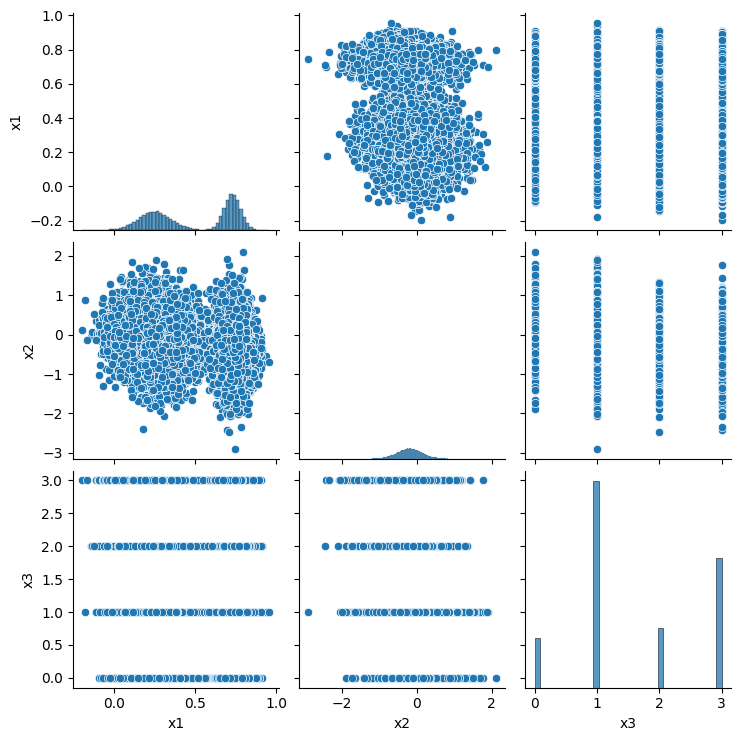

In [5]:
sns.pairplot(df)

In [6]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 80000, Validation size: 10000, Test size: 10000


In [7]:
train_df.to_csv("/home/bule/TramDag/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes_train.csv")

In [8]:
data_type= {'x1':'continous','x2':'continous','x3':'ordinal_Xn_Yo'} 
write_data_type_to_configuration(data_type, CONF_DICT_PATH)

---------------------------------------------------------------------------------------------------------
                                       |                       MODEL SETTINGS                       
Variable             | dtype           | As Predictor                   | As Target                     
---------------------------------------------------------------------------------------------------------
x1                   | continous       | continuous [c]                 | continuous [c]                
x2                   | continous       | continuous [c]                 | continuous [c]                
x3                   | ordinal_Xn_Yo   | ordinal [0,…,K]                | ordinal    [0,…,K]            
---------------------------------------------------------------------------------------------------------
Configuration updated successfully.


/home/bule/TramDag/utils/configuration.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


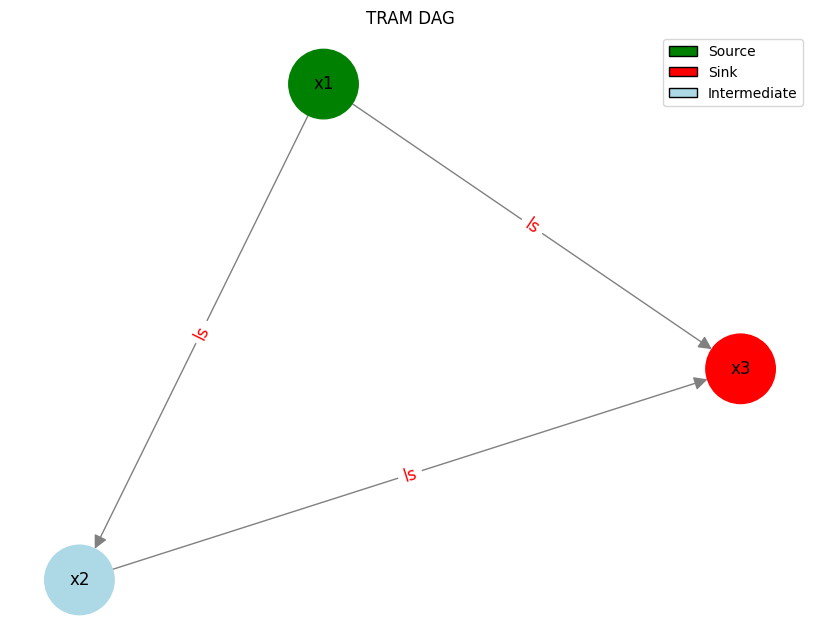

In [9]:
interactive_adj_matrix(CONF_DICT_PATH,seed=19)

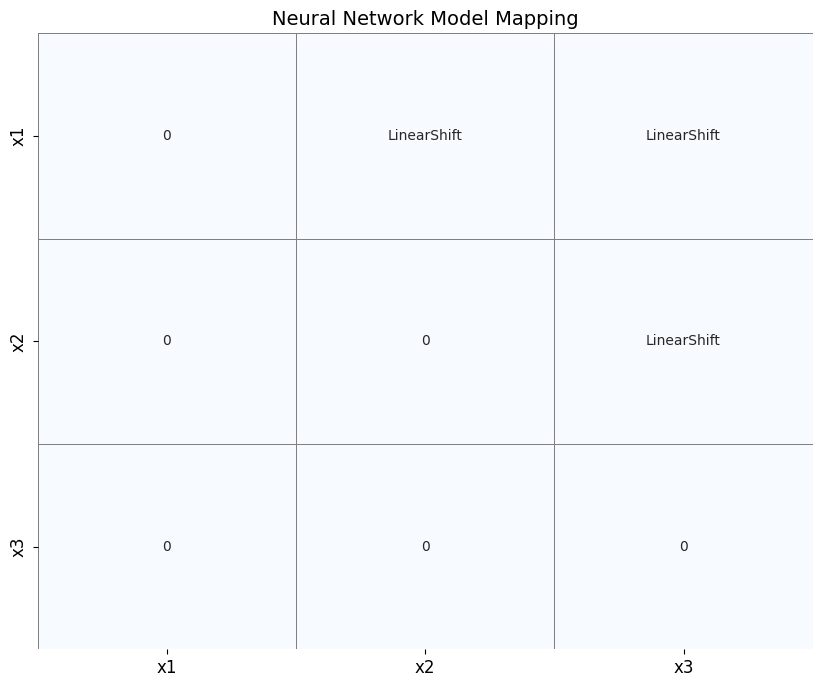

In [10]:
interactive_nn_names_matrix(CONF_DICT_PATH, seed=5)

In [11]:
from utils.tramdag import TramDagConfig , TramDagModel

cfg = TramDagConfig.load(f"/home/bule/TramDag/dev_experiment_logs/{experiment_name}/configuration.json")
cfg.compute_levels(train_df)
device='cpu'

In [12]:
td_model = TramDagModel.from_config(cfg, set_initial_weights=False,verbose=True,debug=True,device=device,initial_data = train_df) 
# 

[DEBUG] TramDagModel using device: cpu

[INFO] Building model for node 'x1' with settings: {'set_initial_weights': False, 'debug': True, 'verbose': True, 'device': 'cpu', 'initial_data':              x1        x2  x3
75220  0.729475 -0.573516   0
48955  0.212327 -0.198221   3
44966  0.219109  0.129154   1
13568  0.777640  0.816980   1
92727  0.357308 -0.411472   3
...         ...       ...  ..
6265   0.700518 -0.365170   0
54886  0.217960 -0.776592   2
76820  0.209427 -0.405457   3
860    0.741015  0.424173   0
15795  0.722792 -0.405650   2

[80000 rows x 3 columns]}
[DEBUG] get_fully_specified_tram_model(): device: cpu
[DEBUG] default_number_thetas for continuous outcomes: 20
[DEBUG] Skipped saving initial model for node 'x1' (already exists at /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x1/initial_model.pt)

[INFO] Building model for node 'x2' with settings: {'set_initial_weights': False, 'debug': True, 'verbose': True, 'device': 'c

In [13]:
td_model.load_or_compute_minmax(td_train_data=train_df)

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/min_max_scaling.json


In [ ]:
td_model.fit(train_df, val_df,
            #  train_list=['target'],
             learning_rate=1e-2,
             epochs=300,batch_size=1000,
             save_linear_shifts=True,
             save_simple_intercepts=True,
             verbose=True,debug=False,
             device=device,
             num_workers = 8,
             persistent_workers = True,
             prefetch_factor = 8,
             train_mode = "sequential")#,

#30 eps 1m 49s seq mode from start 1000 bs
#30 eps 2m 27s parllel multiprocessing mode from start 1000 bs
# 200 eps 9m 30s seq mode from start 1000 bs

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/min_max_scaling.json
[INFO] Training 3 nodes (sequential) on cpu

[INFO] Training node 'x1' for 300 epochs on cpu (pid=1119355)
[INFO] Existing model found. Loading weights and history...

[INFO] Training node 'x2' for 300 epochs on cpu (pid=1119355)
[INFO] Existing model found. Loading weights and history...

[INFO] Training node 'x3' for 300 epochs on cpu (pid=1119355)
[INFO] Existing model found. Loading weights and history...


[INFO] Loaded training/validation histories for 3 nodes.


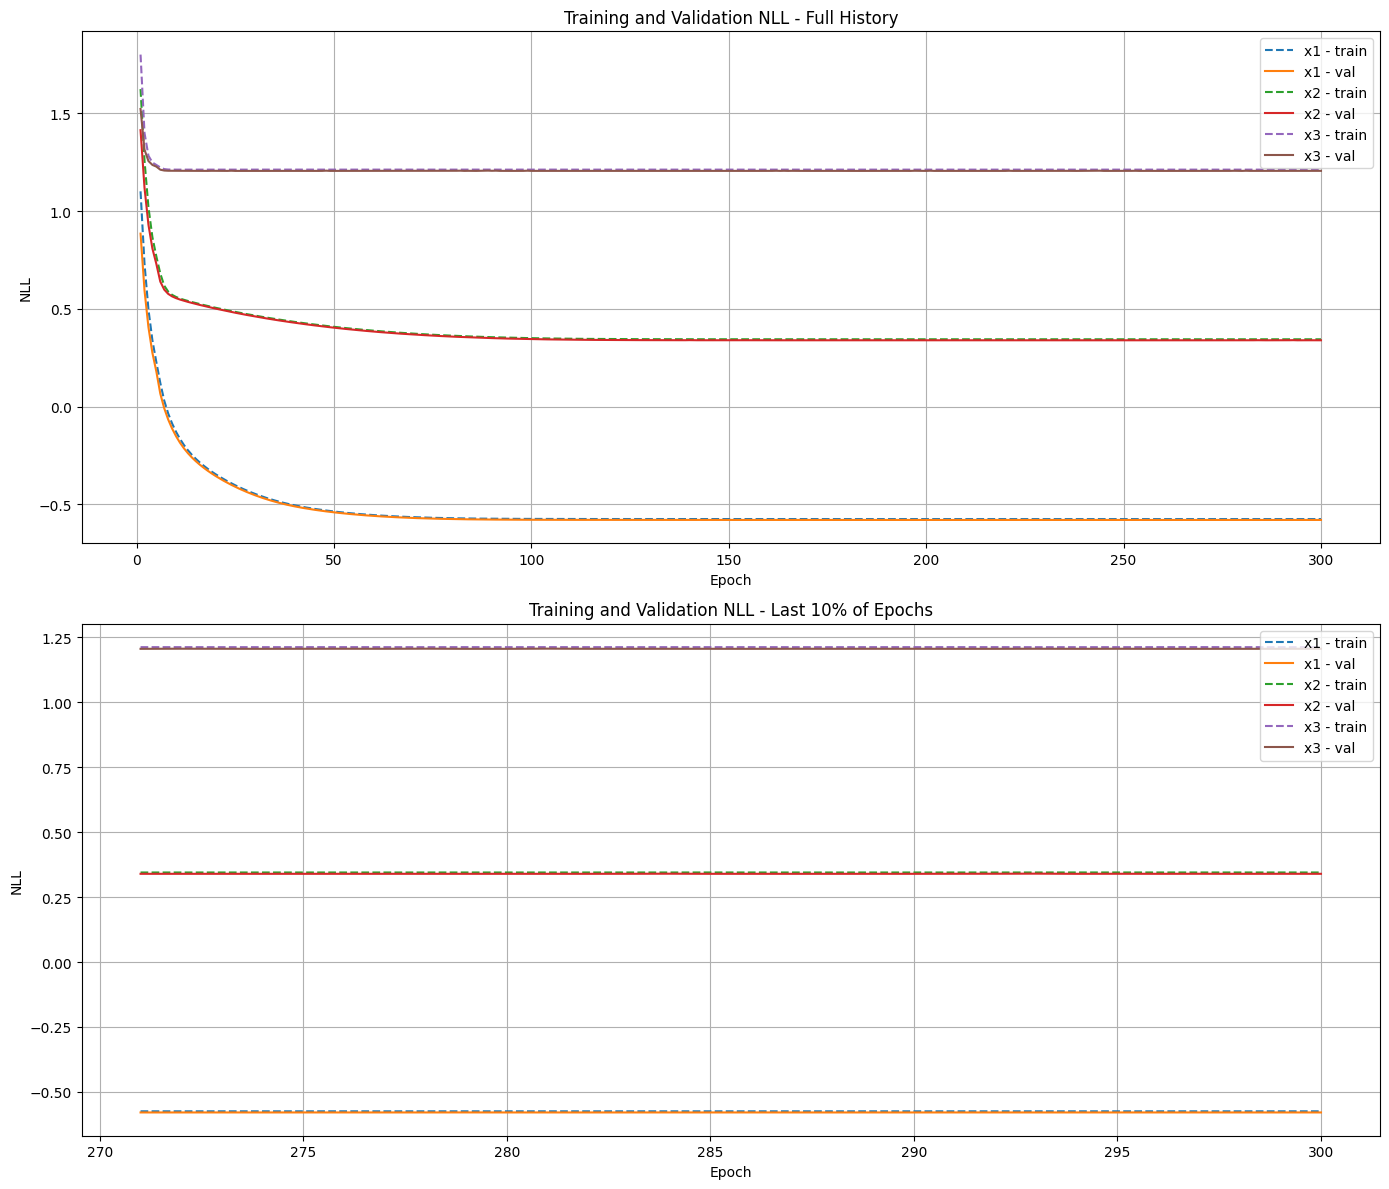

In [ ]:
td_model.plot_loss_history()

[WARNING] No linear shift history found for node 'x1' at /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x1/linear_shifts_all_epochs.json


/home/bule/TramDag/utils/tramdag.py:1569: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


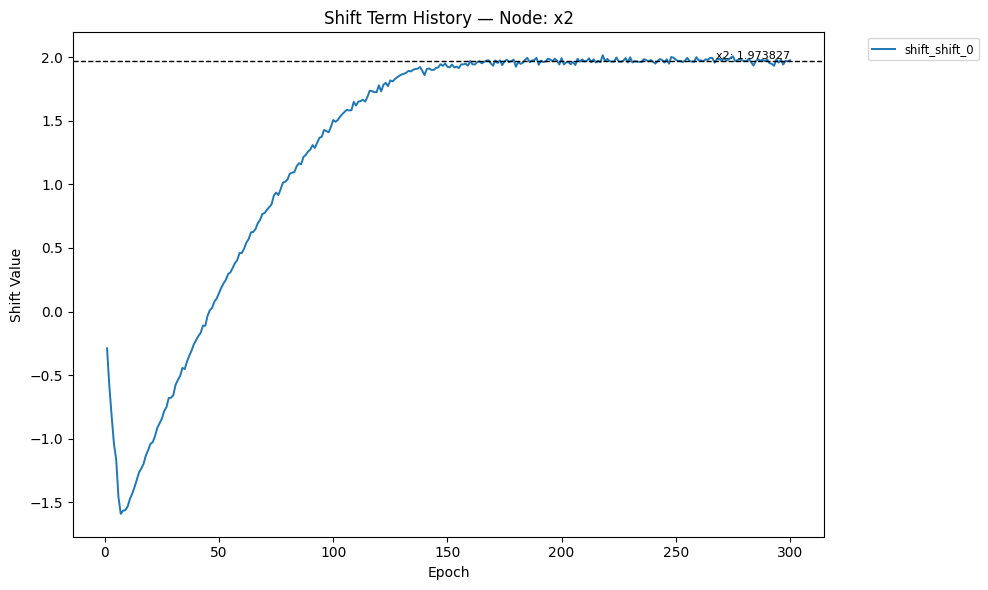

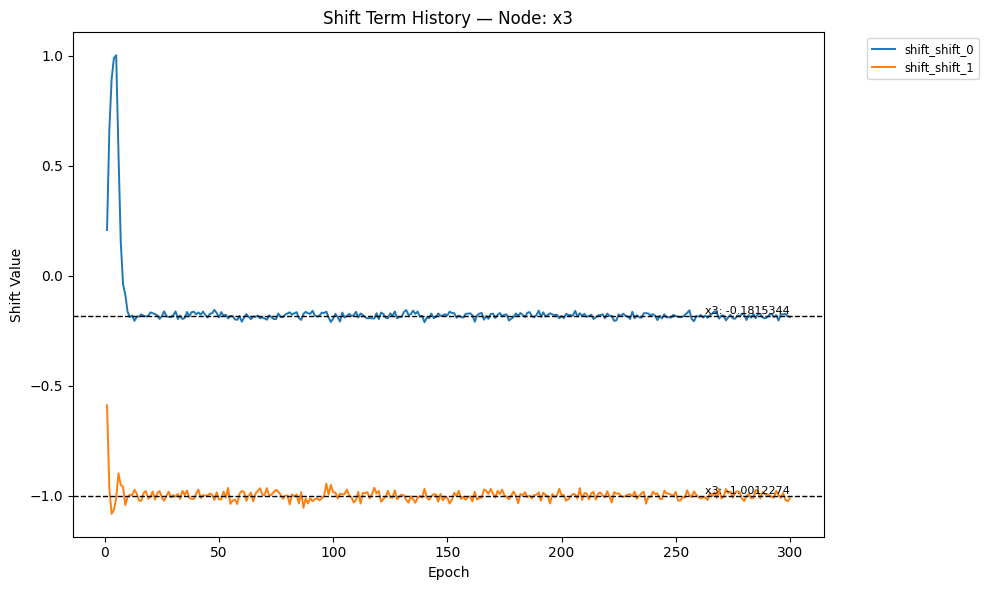

In [ ]:
td_model.plot_shift_histories(ref_lines={'x2':[1.973827],'x3':[-0.1815344, -1.0012274 ]})




/home/bule/TramDag/utils/tramdag.py:1626: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(extract_scalar)


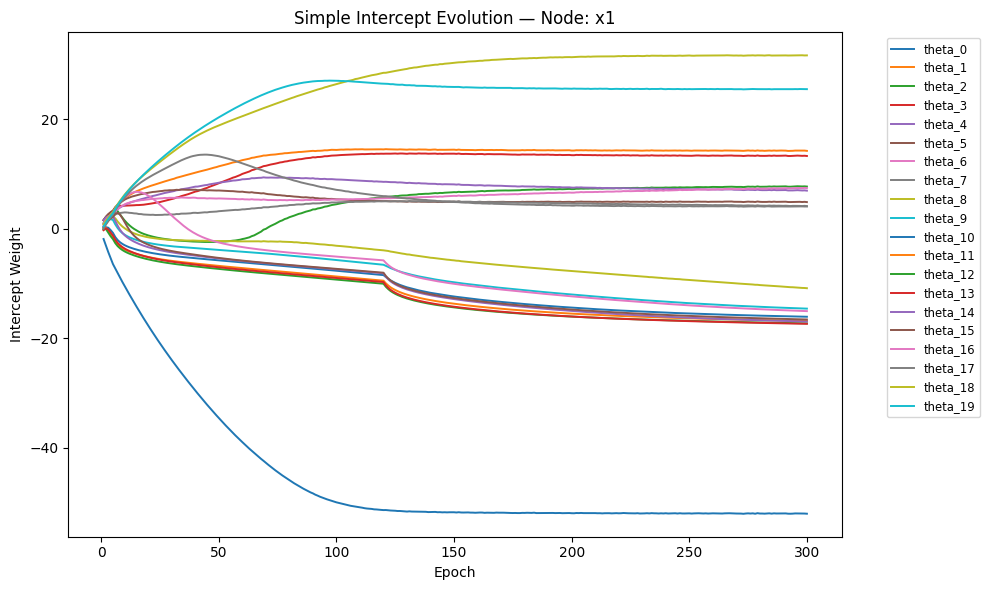

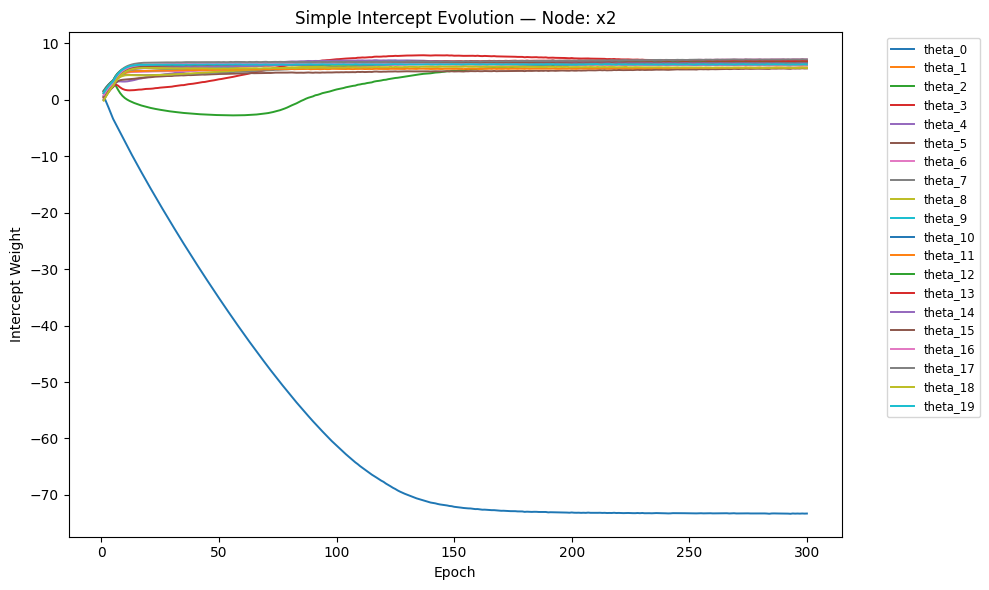

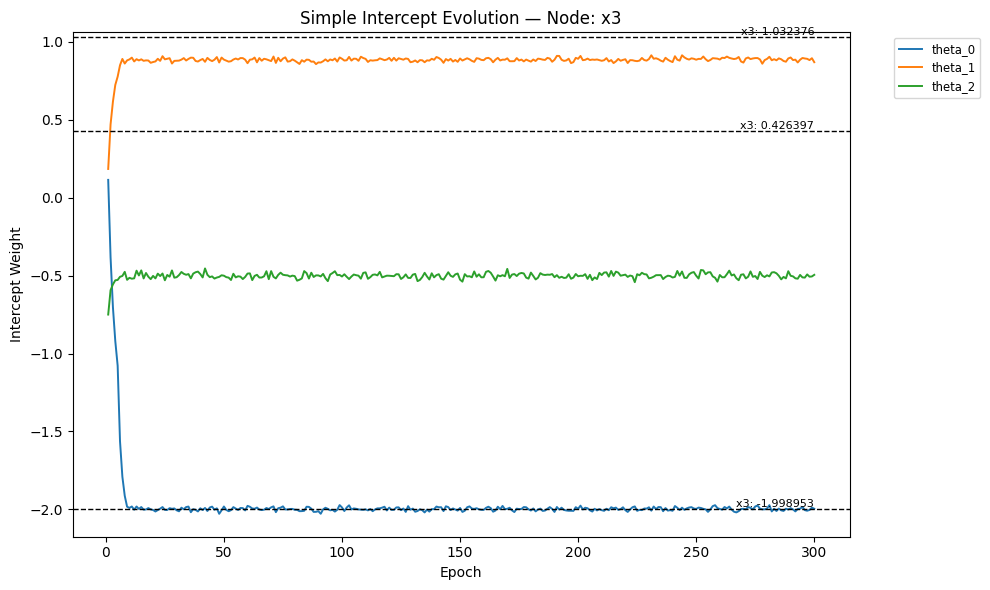

In [ ]:
td_model.plot_simple_intercepts(ref_lines={'x3':[-1.998953,  0.426397,  1.032376]})

In [ ]:
([-2.0, 0.42, 1.02])

[-2.0, 0.42, 1.02]

In [13]:
td_model.load_or_compute_minmax(td_train_data=train_df)

[INFO] Computing new minmax dict from training data...
[INFO] Saved new minmax dict to /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/min_max_scaling.json


In [14]:
rsamples, latents = td_model.sample()

[DEBUG] sample(): device: cpu
[INFO] Starting full DAG sampling with 10000 samples per node.
[DEBUG] sample_full_dag: device: cpu
[INFO] Deleting all previously sampled data.
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x1/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x2/sampling
Directory does not exist: /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x3/sampling

----*----------*-------------*--------Sample Node: x1 ------------*-----------------*-------------------*--
[INFO] Sampling new latents for node x1 from standard logistic distribution
[DEBUG] get_fully_specified_tram_model(): device: cpu
[DEBUG] default_number_thetas for continuous outcomes: 20


FileNotFoundError: [Errno 2] No such file or directory: '/home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x1/best_model.pt'

In [16]:
td_model.show_samples_vs_true(train_df)

[WARNING] skip x1: /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x1/sampling/sampled.pt not found.
[WARNING] skip x2: /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x2/sampling/sampled.pt not found.
[WARNING] skip x3: /home/bule/TramDag/dev_experiment_logs/dev_API_Reproduce_TramDag_Experiment_6_2_mixed_datatypes/x3/sampling/sampled.pt not found.
